In [1]:
import pymongo
import pandas as pd
import numpy as np
import math
from datetime import datetime

# import dask.dataframe as dd ## ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
# import vaex ## ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨

# from sklearn.linear_model import LinearRegression ## likes, dislikes ÎåÄÏ≤¥
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import os
from dotenv import load_dotenv

In [2]:
file_path = 'C:/py_src/awake/data/'

In [3]:
# Í≥ÑÏ†ï / ÏΩòÌÖêÏ∏† Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÏÖã Î∂àÎü¨Ïò§Í∏∞
merge_df_users_fin = pd.read_csv(file_path + 'merge_df_users_fin.csv', low_memory=False)
youtube_videos = pd.read_csv(file_path + 'youtube_videos.csv')

## Í≥ÑÏ†ï Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù

### Í∏∞Ï¥àÌÜµÍ≥Ñ

In [4]:
# Í∏∞Ï¥àÌÜµÍ≥Ñ
merge_df_users_fin[merge_df_users_fin.columns[11:-16]].describe()

views      redViews  UNSUBSCRIBED    SUBSCRIBED       comments  \
count  1.056830e+05  1.056830e+05  1.056830e+05  1.056830e+05  105683.000000   
mean   7.669704e+04  1.181762e+04  5.780240e+04  8.794060e+03      36.601629   
std    9.172899e+05  6.232938e+04  7.977084e+05  1.190782e+05     326.696229   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    3.290000e+02  8.700000e+01  9.100000e+01  3.000000e+00       0.000000   
50%    1.844000e+03  4.900000e+02  9.020000e+02  7.600000e+01       1.000000   
75%    1.212200e+04  3.405500e+03  6.649500e+03  8.305000e+02       9.000000   
max    4.064898e+07  1.862117e+06  3.707229e+07  4.546611e+06   35931.000000   

              likes         shares       dislikes  estimatedMinutesWatched  \
count  1.056830e+05  105683.000000  105683.000000             1.056830e+05   
mean   3.968254e+03     122.175610      38.654117             8.683548e+04   
std    7.623700e+04    1486.124555     462.391495             8.077970e+05   
min   -1.755000e+03       0.000000    -426.000000             0.000000e+00   
25%    2.000000e+00       1.000000       0.000000             5.450000e+02   
50%    2.000000e+01       6.000000       1.000000             2.694000e+03   
75%    1.620000e+02      33.000000       5.000000             2.045400e+04   
max    3.054524e+06   64529.000000   24353.000000             3.330760e+07   

       averageViewDuration  averageViewPercentage  estimated_revenue  \
count        105683.000000          105683.000000       1.056830e+05   
mean              2.590939              35.047682       2.877474e+04   
std               6.506950              55.212625       1.318711e+05   
min               0.000000               0.000000      -1.127185e+06   
25%               0.780000              16.680000       1.175040e+02   
50%               1.580000              28.000000       1.480631e+03   
75%               2.580000              47.680000       1.108485e+04   
max             120.230000           15049.760000       5.338431e+06   

       estimated_ad_revenue  estimated_red_partner_revenue  gross_revenue  \
count          1.056830e+05                  105683.000000   1.056830e+05   
mean           1.501653e+04                    3248.437925   2.722400e+04   
std            6.781683e+04                   13148.516236   1.231992e+05   
min            0.000000e+00                       0.000000   0.000000e+00   
25%            4.842900e+01                       8.373500   8.782450e+01   
50%            8.320230e+02                     132.648000   1.504621e+03   
75%            5.085199e+03                    1021.478500   9.190117e+03   
max            3.082096e+06                  388432.785000   5.601879e+06   

                 cpm  playback_based_cpm  subscribers_count  \
count  105683.000000       105683.000000       1.056830e+05   
mean     5030.826465         5499.273283       6.988129e+04   
std     22890.346092         6556.226151       1.789418e+05   
min         0.000000            0.000000       0.000000e+00   
25%        24.000000         3232.250500       3.530000e+03   
50%       328.000000         5155.512000       1.506600e+04   
75%      2119.000000         7229.389500       5.203100e+04   
max    994860.000000       489556.625000       3.442657e+06   

       subscribers_gained  subscribers_lost  
count       105683.000000     105683.000000  
mean           125.901574         41.760690  
std           1278.900197        348.199082  
min              0.000000          0.000000  
25%              1.000000          1.000000  
50%              8.000000          5.000000  
75%             43.000000         22.000000  
max          77446.000000      18821.000000

In [5]:
# ÏûòÎ™ªÎêúÍ∞í Ï≤òÎ¶¨
merge_df_users_fin['estimated_revenue'] = np.where(merge_df_users_fin['estimated_revenue'] < 0,
                                                   merge_df_users_fin['estimated_ad_revenue'] + merge_df_users_fin['estimated_red_partner_revenue'],
                                                   merge_df_users_fin['estimated_revenue'])

### ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ

In [6]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
users_corr_matrix = merge_df_users_fin[merge_df_users_fin.columns[11:-16]].corr()
users_corr_matrix

views  redViews  UNSUBSCRIBED  SUBSCRIBED  \
views                          1.000000  0.887237      0.990442    0.943630   
redViews                       0.887237  1.000000      0.852712    0.829370   
UNSUBSCRIBED                   0.990442  0.852712      1.000000    0.936746   
SUBSCRIBED                     0.943630  0.829370      0.936746    1.000000   
comments                       0.513510  0.505902      0.490312    0.529463   
likes                          0.989553  0.830601      0.985804    0.950954   
shares                         0.977800  0.835948      0.972716    0.921654   
dislikes                       0.988343  0.870122      0.976795    0.925751   
estimatedMinutesWatched        0.977856  0.871829      0.967478    0.945687   
averageViewDuration           -0.018855 -0.036296     -0.016759   -0.011540   
averageViewPercentage          0.037667  0.070093      0.044962    0.037588   
estimated_revenue              0.707427  0.746953      0.677054    0.769096   
estimated_ad_revenue           0.527626  0.569576      0.511655    0.591106   
estimated_red_partner_revenue  0.564268  0.670893      0.537700    0.603220   
gross_revenue                  0.528796  0.570658      0.512832    0.592372   
cpm                            0.512862  0.574717      0.498079    0.569441   
playback_based_cpm             0.015210  0.007111      0.015871    0.028896   
subscribers_count              0.476780  0.567356      0.457118    0.535358   
subscribers_gained             0.945025  0.807065      0.947833    0.840056   
subscribers_lost               0.957050  0.830827      0.953924    0.905884   

                               comments     likes    shares  dislikes  \
views                          0.513510  0.989553  0.977800  0.988343   
redViews                       0.505902  0.830601  0.835948  0.870122   
UNSUBSCRIBED                   0.490312  0.985804  0.972716  0.976795   
SUBSCRIBED                     0.529463  0.950954  0.921654  0.925751   
comments                       1.000000  0.500979  0.497708  0.524899   
likes                          0.500979  1.000000  0.984213  0.977959   
shares                         0.497708  0.984213  1.000000  0.967875   
dislikes                       0.524899  0.977959  0.967875  1.000000   
estimatedMinutesWatched        0.503878  0.970689  0.964019  0.962861   
averageViewDuration           -0.019573 -0.013458 -0.006929 -0.020414   
averageViewPercentage          0.043904  0.027295  0.028528  0.037492   
estimated_revenue              0.439432  0.680034  0.686037  0.692621   
estimated_ad_revenue           0.325125  0.505728  0.529940  0.500523   
estimated_red_partner_revenue  0.350781  0.524644  0.542907  0.548045   
gross_revenue                  0.325862  0.506934  0.530864  0.501676   
cpm                            0.323164  0.484658  0.506659  0.484593   
playback_based_cpm             0.007777  0.018521  0.024675  0.012684   
subscribers_count              0.312102  0.441308  0.447388  0.452646   
subscribers_gained             0.504283  0.936573  0.938846  0.958289   
subscribers_lost               0.524476  0.951134  0.945531  0.962212   

                               estimatedMinutesWatched  averageViewDuration  \
views                                         0.977856            -0.018855   
redViews                                      0.871829            -0.036296   
UNSUBSCRIBED                                  0.967478            -0.016759   
SUBSCRIBED                                    0.945687            -0.011540   
comments                                      0.503878            -0.019573   
likes                                         0.970689            -0.013458   
shares                                        0.964019            -0.006929   
dislikes                                      0.962861            -0.020414   
estimatedMinutesWatched                       1.000000             0.082526   
averageViewDuration                           0.08

In [7]:
# Î≤ÑÍ∑∏Î°ú ÏÇ¨Ïö©Îêú ÏàòÏπòÍ∞í ÎåÄÏ≤¥
merge_df_users_fin['likes'] = np.where(merge_df_users_fin['likes'] < 0, 0, merge_df_users_fin['likes'])
merge_df_users_fin['dislikes'] = np.where(merge_df_users_fin['dislikes'] < 0, 0, merge_df_users_fin['dislikes'])

### ÌååÏÉùÎ≥ÄÏàò

In [8]:
# ÌååÏÉùÎ≥ÄÏàò1 - Ï∞∏Ïó¨ÎèÑ Í¥ÄÎ†®
merge_df_users_fin['like_rate'] = merge_df_users_fin['likes'] / merge_df_users_fin['views'] ## Ï¢ãÏïÑÏöî ÎπÑÏú® 
merge_df_users_fin['comment_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['views'] ## ÎåìÍ∏Ä ÎπÑÏú®
merge_df_users_fin['share_rate'] = merge_df_users_fin['shares'] / merge_df_users_fin['views'] ## Í≥µÏú† ÎπÑÏú®  
merge_df_users_fin['dislike_rate'] = merge_df_users_fin['dislikes'] / merge_df_users_fin['views'] ## Ïã´Ïñ¥Ïöî ÎπÑÏú®
merge_df_users_fin['total_engage_rate'] = (merge_df_users_fin['likes'] + merge_df_users_fin['comments'] + merge_df_users_fin['shares'] + merge_df_users_fin['dislikes']) / merge_df_users_fin['views'] ## Ï¥ù Ï∞∏Ïó¨Ïú®
merge_df_users_fin['positive_engage_rate'] = (merge_df_users_fin['likes'] + merge_df_users_fin['shares']) / merge_df_users_fin['views'] ## Í∏çÏ†ïÏ†Å Ï∞∏Ïó¨Ïú®
merge_df_users_fin['comment_to_like_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['likes'] ## ÎåìÍ∏Ä/Ï¢ãÏïÑÏöî ÎπÑÏú®
merge_df_users_fin['like_to_dislike_ratio'] = merge_df_users_fin['likes'] / (merge_df_users_fin['dislikes']) ## Ï¢ãÏïÑÏöî/Ïã´Ïñ¥Ïöî ÎπÑÏú®

In [9]:
# ÌååÏÉùÎ≥ÄÏàò2 - Íµ¨ÎèÖÏûê Í¥ÄÎ†®
merge_df_users_fin['subscriber_increase_rate'] = merge_df_users_fin['subscribers_gained'] / merge_df_users_fin['subscribers_count'] ## Íµ¨ÎèÖÏûê Ï¶ùÍ∞ÄÏú®
merge_df_users_fin['subscriber_decrease_rate'] = merge_df_users_fin['subscribers_lost'] / merge_df_users_fin['subscribers_count'] ## Íµ¨ÎèÖÏûê Í∞êÏÜåÏú®
merge_df_users_fin['net_subscribers_change'] = merge_df_users_fin['subscribers_gained'] - merge_df_users_fin['subscribers_lost'] ## Íµ¨ÎèÖÏûê ÏàúÏ¶ùÍ∞Ä
merge_df_users_fin['subscribers_conversion_rate'] = merge_df_users_fin['subscribers_gained'] / merge_df_users_fin['views'] ## Íµ¨ÎèÖÏûê Ï†ÑÌôòÏú®
merge_df_users_fin['subscriber_retention_rate'] = (merge_df_users_fin['SUBSCRIBED'] - merge_df_users_fin['UNSUBSCRIBED']) / merge_df_users_fin['subscribers_count'] ## Íµ¨ÎèÖÏûê Ïú†ÏßÄÏú®
merge_df_users_fin['subscribed_view_rate'] = merge_df_users_fin['SUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## Íµ¨ÎèÖÏûê Ï°∞ÌöåÏàò ÎπÑÏú®
merge_df_users_fin['unsubscribed_view_rate'] = merge_df_users_fin['UNSUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## ÎπÑÍµ¨ÎèÖÏûê Ï°∞ÌöåÏàò ÎπÑÏú®

In [10]:
# ÌååÏÉùÎ≥ÄÏàò3 - ÏàòÏùµ Í¥ÄÎ†®
merge_df_users_fin['revenue_per_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['views'] ## Ï°∞ÌöåÏàòÎãπ ÏàòÏùµ
merge_df_users_fin['revenue_per_subscribed_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['SUBSCRIBED'] ## Íµ¨ÎèÖÏûêÏ°∞ÌöåÏàòÎãπ ÏàòÏùµ
merge_df_users_fin['revenue_per_unsubscribed_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['UNSUBSCRIBED'] ## ÎπÑÍµ¨ÎèÖÏûêÏ°∞ÌöåÏàòÎãπ ÏàòÏùµ
merge_df_users_fin['revenue_per_subscriber'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['subscribers_count'] ## Íµ¨ÎèÖÏûêÎãπ ÏàòÏùµ
merge_df_users_fin['revenue_per_red_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['redViews'] ## ÌîÑÎ¶¨ÎØ∏ÏóÑÎãπ ÏàòÏùµ
merge_df_users_fin['ad_revenue_rate'] = merge_df_users_fin['estimated_ad_revenue'] / merge_df_users_fin['estimated_revenue'] ## Í¥ëÍ≥†ÏàòÏùµÎπÑÏú®
merge_df_users_fin['red_revenue_rate'] = merge_df_users_fin['estimated_red_partner_revenue'] / merge_df_users_fin['estimated_revenue'] ## ÌîÑÎ¶¨ÎØ∏ÏóÑÏàòÏùµÎπÑÏú®
merge_df_users_fin['cpm_to_revenue_ratio'] = merge_df_users_fin['cpm'] / merge_df_users_fin['estimated_revenue'] ## cpm ÎåÄÎπÑ ÏàòÏùµ
merge_df_users_fin['revenue_per_ad_impression'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['ad_impressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂úÎãπ ÏàòÏùµ
merge_df_users_fin['playback_based_cpm_rate'] = merge_df_users_fin['playback_based_cpm'] / merge_df_users_fin['cpm'] ## Ïû¨ÏÉù Í∏∞Î∞ò ÏàòÏùµ

In [11]:
# ÌååÏÉùÎ≥ÄÏàò4 - ÏãúÏ≤≠ ÏãúÍ∞Ñ Í¥ÄÎ†®
merge_df_users_fin['revenue_per_minute_watched'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['estimatedMinutesWatched'] ## ÏãúÏ≤≠ ÏãúÍ∞Ñ Îãπ ÏàòÏùµ
merge_df_users_fin['avg_view_duration_rate'] = merge_df_users_fin['averageViewDuration'] / merge_df_users_fin['averageViewPercentage'] ## ÌèâÍ∑† ÏãúÏ≤≠ ÏãúÍ∞Ñ ÎπÑÏú®
merge_df_users_fin['watched_time_rate'] = merge_df_users_fin['averageViewPercentage'] * merge_df_users_fin['estimatedMinutesWatched'] ## Ïû¨ÏÉù ÎπÑÏú® ÎåÄÎπÑ ÏãúÏ≤≠ ÏãúÍ∞Ñ
merge_df_users_fin['watched_view_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['views'] ## Ï°∞ÌöåÏàòÎãπ ÏãúÏ≤≠ÏãúÍ∞Ñ
merge_df_users_fin['subscribed_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['SUBSCRIBED'] ## Íµ¨ÎèÖÏûêÏ°∞ÌöåÏàòÎãπ ÏãúÏ≤≠ÏãúÍ∞Ñ
merge_df_users_fin['unsubscribed_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['UNSUBSCRIBED'] ## ÎπÑÍµ¨ÎèÖÏûêÏ°∞ÌöåÏàòÎãπ ÏãúÏ≤≠ÏãúÍ∞Ñ
merge_df_users_fin['subscriber_view_time_rate'] = merge_df_users_fin['estimatedMinutesWatched'] / merge_df_users_fin['subscribers_count'] ## Íµ¨ÎèÖÏûêÎãπ ÏãúÏ≤≠ÏãúÍ∞Ñ

In [12]:
# ÌååÏÉùÎ≥ÄÏàò5 - Í¥ëÍ≥† Í¥ÄÎ†®
merge_df_users_fin['revenue_per_playback'] = merge_df_users_fin['gross_revenue'] / merge_df_users_fin['monetized_playbacks'] ## 1Ìöå Í¥ëÍ≥†Ïû¨ÏÉùÎãπ ÏàòÏùµ
merge_df_users_fin['gross_revenue_per_ad_impression'] = merge_df_users_fin['gross_revenue'] / merge_df_users_fin['ad_impressions'] ## 1Ìöå Í¥ëÍ≥†ÎÖ∏Ï∂úÎãπ Ï¥ùÏàòÏùµ
merge_df_users_fin['playback_rate'] = merge_df_users_fin['monetized_playbacks'] / merge_df_users_fin['ad_impressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂ú ÎåÄÎπÑ Ïû¨ÏÉùÏú®
merge_df_users_fin['unplayback_rate'] = (merge_df_users_fin['ad_impressions'] - merge_df_users_fin['monetized_playbacks']) / merge_df_users_fin['ad_impressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂ú ÎåÄÎπÑ ÎπÑÏû¨ÏÉùÏú®

In [13]:
# ÌååÏÉùÎ≥ÄÏàò6 - Ïó∞Î†π Î∞è ÏÑ±Î≥Ñ Í¥ÄÎ†®
female_col = [col_nm for col_nm in merge_df_users_fin.columns if 'female' in col_nm ]
male_col = [col_nm for col_nm in merge_df_users_fin.columns if ('male' in col_nm) and ('female' not in col_nm)]

youth_col = [col_nm for col_nm in merge_df_users_fin.columns if '13-17' in col_nm]
adult_col = [col_nm for col_nm in merge_df_users_fin.columns if ('18-24' in col_nm) or ('25-34' in col_nm) or ('35-44' in col_nm) or ('45-54' in col_nm)]
older_col = [col_nm for col_nm in merge_df_users_fin.columns if ('55-64' in col_nm) or ('65' in col_nm)]

merge_df_users_fin['female_viewer_rate'] = merge_df_users_fin[female_col].sum(axis=1) ## Ïó¨ÏÑ± ÏãúÏ≤≠Ïûê ÎπÑÏú®
merge_df_users_fin['male_viewer_rate'] = merge_df_users_fin[male_col].sum(axis=1) ## ÎÇ®ÏÑ± ÏãúÏ≤≠Ïûê ÎπÑÏú®

merge_df_users_fin['youth_viewer_rate'] = merge_df_users_fin[youth_col].sum(axis=1) ## Ï≤≠ÏÜåÎÖÑ ÏãúÏ≤≠Ïûê ÎπÑÏú®
merge_df_users_fin['adult_viewer_rate'] = merge_df_users_fin[adult_col].sum(axis=1) ## ÏÑ±Ïù∏ ÏãúÏ≤≠Ïûê ÎπÑÏú®
merge_df_users_fin['older_viewer_rate'] = merge_df_users_fin[older_col].sum(axis=1) ## ÎÖ∏Ïù∏ ÏãúÏ≤≠Ïûê ÎπÑÏú®

In [14]:
# nullÍ∞í ÎåÄÏ≤¥
merge_df_users_fin = merge_df_users_fin.fillna(0) ## NaN
merge_df_users_fin = merge_df_users_fin.replace([np.inf, -np.inf], 0) ## inf

### ÏãúÍ≥ÑÏó¥ ÌôïÏù∏
- Looker Studio ÌôúÏö©

In [14]:
# 'date' Ïª¨ÎüºÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
merge_df_users_fin['date'] = pd.to_datetime(merge_df_users_fin['date'])

# Ï£º(week) Ïª¨Îüº ÏÉùÏÑ± (ISO Ï£º Î≤àÌò∏ Í∏∞Ï§Ä)
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].dt.isocalendar().week
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_week'].astype(str)
merge_df_users_fin['date_week'] = pd.to_datetime(merge_df_users_fin['date_week'] + '-1', format='%Y-%W-%w') ## looker studio ÎÇ†Ïßú ÌòïÏãù ÏúÑÌï¥ Ï£ºÎßàÎã§ ÏõîÏöîÏùº ÎÇ†ÏßúÎ°ú Î≥ÄÍ≤Ω
merge_df_users_fin['date_week'] = merge_df_users_fin['date_week'].astype(str)

# Ïõî(month) Ïª¨Îüº ÏÉùÏÑ±
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].dt.month
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_month'].fillna(0).astype(int).astype(str)
merge_df_users_fin['date_month'] = np.where(merge_df_users_fin['date_month']=='NaT-0','',merge_df_users_fin['date_month'])

# Î∂ÑÍ∏∞(quarter) Ïª¨Îüº ÏÉùÏÑ±
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].dt.to_period('Q').dt.quarter
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_quarter'].fillna(0).astype(str)
merge_df_users_fin['date_quarter'] = np.where(merge_df_users_fin['date_quarter']=='NaT--1','',merge_df_users_fin['date_quarter'])

In [15]:
merge_df_users_looker = merge_df_users_fin[['youtube_user_id','date','date_week','date_month','date_quarter','viewCount','subscriberCount','videoCount',
                                            'views','estimated_revenue','subscribers_count','estimatedMinutesWatched','averageViewDuration',
                                            'total_engage_rate','net_subscribers_change','averageViewPercentage','revenue_per_view',
                                            'female_viewer_rate', 'male_viewer_rate', 'youth_viewer_rate', 'adult_viewer_rate', 'older_viewer_rate']]

In [101]:
# merge_df_users_looker.to_csv('C:/py_src/awake/data/merge_df_users_looker.csv', encoding='utf-8-sig', index=False)

### yÍ∞í ÏÑ§Ï†ï

#### Ï§ëÏöî ÏßÄÌëú ÌëúÏ§ÄÌôî

In [20]:
# yÍ∞í ÌôúÏö© ÏßÄÌëú
y_col = ['total_engage_rate', 'net_subscribers_change', 'averageViewPercentage', 'revenue_per_view', 'gross_revenue_per_ad_impression'] ## nullÍ∞íÏùÄ viewsÍ∞Ä 0Ïù∏ Îç∞Ïù¥ÌÑ∞

In [21]:
# nullÍ∞í ÎåÄÏ≤¥
merge_df_users_fin[y_col] = merge_df_users_fin[y_col].fillna(0) ## NaN
merge_df_users_fin[y_col] = merge_df_users_fin[y_col].replace([np.inf, -np.inf], 0) ## inf

In [22]:
# ÌëúÏ§ÄÌôî (Standard Scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merge_df_users_fin[y_col])

#### Îã§Ï§ë ÏßÄÌëú Í≤∞Ìï©

In [23]:
# Isolation Forest Î™®Îç∏ ÌïôÏäµ
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Ïù¥ÏÉÅÏπò ÎπÑÏú® ÏÑ§Ï†ï
iso_forest.fit(scaled_features)

# Ïù¥ÏÉÅÏπò Ï†êÏàò Í≥ÑÏÇ∞
anomaly_scores = iso_forest.decision_function(scaled_features)

In [24]:
# ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
threshold = np.percentile(anomaly_scores, 5) ## Ïù¥ÏÉÅÏπò Ï†êÏàòÍ∞Ä ÏûëÏùÑÏàòÎ°ù Ïù¥ÏÉÅÏπòÏóê Í∞ÄÍπùÎã§Í≥† ÌåêÎã®ÌïòÎäîÎç∞, 5Î≤àÏß∏ Î∞±Î∂ÑÏúÑÏàòÍ∞Ä (-)Î°ú Î∞îÎÄåÎäî Ìè¨Ïù∏Ìä∏

# yÍ∞í ÎùºÎ≤®ÎßÅ (Ïù¥ÏÉÅÏπòÏù¥Î©¥ 0, Í∑∏Î†áÏßÄ ÏïäÏúºÎ©¥ 1)
merge_df_users_fin['y_label'] = np.where(anomaly_scores < threshold, 0, 1)

In [25]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ yÍ∞í ÎπàÎèÑ ÌôïÏù∏
merge_df_users_fin['y_label'].value_counts()

y_label
1    100398
0      5285
Name: count, dtype: int64

In [32]:
# merge_df_users_fin.to_csv('C:/py_src/awake/data/merge_df_users_fin_eda.csv', encoding='utf-8-sig', index=False)

In [27]:
# Í≥ÑÏ†ïÎ≥Ñ yÍ∞í ÎπàÎèÑ Îç∞Ïù¥ÌÑ∞
y_result_df = merge_df_users_fin.groupby('youtube_user_id')['y_label'].value_counts().reset_index()
y_result_df

youtube_user_id  y_label  count
0    627cb611aa6f212355e0b617        1    405
1    627f59ccaa39226247c60b01        1    402
2    627f59ccaa39226247c60b01        0      3
3    6287228afb15712a8cb931d7        1    405
4    6287229efb15712a8cb93225        1    398
..                        ...      ...    ...
394  65e7b773d8da110bb072e2b5        0      1
395  65f7b17ed8da110bb0733b7b        1    405
396  65fecf7ed8da110bb0736199        1    405
397  66230ee6d8da110bb0744b2d        1    373
398  66230ee6d8da110bb0744b2d        0     32

[399 rows x 3 columns]

In [57]:
# Í≥ÑÏ†ïÎ≥Ñ ÏùºÏùºÎç∞Ïù¥ÌÑ∞Ïùò 20% Ïù¥ÏÉÅ Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞Ïù∏ Í≥ÑÏ†ï ÌôïÏù∏
y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]

youtube_user_id  y_label  count
17   62872523fb15712a8cb93479        0     90
54   62a35ce69d41c93ff90b5670        0    110
78   62c4e558507271632b9cc1c7        0     50
85   62d11f080b4c4c7502a5be3d        0    400
131  639bb8dcd603b8138e33780b        0    187
139  63c9075250eb530dfd1346bd        0     46
156  63d77c9650eb530dfd139f8b        0    335
171  63eb4f87ee122e631992279f        0    302
205  640001db0abaa11316396d3b        0    223
218  64020bf4d746c60e1272055f        0    155
222  640339ac118c0f5858818694        0    393
252  64399d0b659261656b3f0681        0    122
270  645da9e6ef566f0e136a83cf        0    123
271  645ec17eef566f0e136a9880        0    321
286  647c9ef719c22b644dddfcb7        0     48
307  649b0fb29247f326464c53f6        0    201
317  64bbf3cd616bd20e30379bf3        0     61
337  64d964e4f638790e0f74a391        0    178
339  64da0ac3f638790e0f74ae7b        0     75
341  64da8a9ef638790e0f74bae7        0    122
350  64ef21f0dcc0250e17c4423b        0    136
359  6508ff021120b40b4427a4fc        0     69
361  6512f58f1120b40b44281d02        0     44
366  653795ed1120b40b4429cbfe        0     59
370  6537f4381120b40b4429df06        0    112
388  65bbb4a905bf1c0baa41e95c        0     66
391  65cc401305bf1c0baa425146        0    152

#### Í∞úÎ≥Ñ ÏßÄÌëúÎ≥Ñ ÌèâÍ∞Ä Ï¢ÖÌï©

In [58]:
thresholds = {}
anomaly_scores_dict = {}

# Í∞Å ÏßÄÌëúÏóê ÎåÄÌï¥ Í∞úÎ≥Ñ ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
for i, feature in enumerate(y_col):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(scaled_features[:,i].reshape(-1, 1))
    anomaly_scores = iso_forest.decision_function(scaled_features[:,i].reshape(-1, 1))
    thresholds[feature] = np.percentile(anomaly_scores, 5)
    anomaly_scores_dict[feature] = anomaly_scores

In [59]:
merge_df_users_fin['y_label2'] = 1  # Í∏∞Î≥∏Í∞íÏùÑ 1Î°ú ÏÑ§Ï†ï (ÏßÑÏßú ÏòÅÌñ•Î†•)

for feature in y_col:
    merge_df_users_fin['y_label2'] = np.where(anomaly_scores_dict[feature] < thresholds[feature], 0, merge_df_users_fin['y_label2'])

In [60]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ yÍ∞í ÎπàÎèÑ ÌôïÏù∏
merge_df_users_fin['y_label2'].value_counts()

y_label2
1    84137
0    21546
Name: count, dtype: int64

In [61]:
# Í≥ÑÏ†ïÎ≥Ñ yÍ∞í ÎπàÎèÑ Îç∞Ïù¥ÌÑ∞
y_result_df2 = merge_df_users_fin.groupby('youtube_user_id')['y_label2'].value_counts().reset_index()
y_result_df2

youtube_user_id  y_label2  count
0    627cb611aa6f212355e0b617         1    399
1    627cb611aa6f212355e0b617         0      6
2    627f59ccaa39226247c60b01         1    328
3    627f59ccaa39226247c60b01         0     77
4    6287228afb15712a8cb931d7         1    405
..                        ...       ...    ...
486  65f7b17ed8da110bb0733b7b         0      6
487  65fecf7ed8da110bb0736199         1    399
488  65fecf7ed8da110bb0736199         0      6
489  66230ee6d8da110bb0744b2d         1    219
490  66230ee6d8da110bb0744b2d         0    186

[491 rows x 3 columns]

In [62]:
# Í≥ÑÏ†ïÎ≥Ñ ÏùºÏùºÎç∞Ïù¥ÌÑ∞Ïùò 20% Ïù¥ÏÉÅ Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞Ïù∏ Í≥ÑÏ†ï ÌôïÏù∏
y_result_df2[y_result_df2['y_label2']==0][y_result_df2[y_result_df2['y_label2']==0]['count'] >= 80]

youtube_user_id  y_label2  count
6    6287229efb15712a8cb93225         0     86
25   62872523fb15712a8cb93479         0    210
29   628727e1fb15712a8cb9353b         0    170
52   6294ab84fe241a32a48ada00         0    151
62   629f6ca6eaf5732d6df0611e         0    372
..                        ...       ...    ...
469  65a3f25864b4250ba696579a         0    243
477  65bbb4a905bf1c0baa41e95c         0    167
481  65cc401305bf1c0baa425146         0    160
484  65e7b773d8da110bb072e2b5         0     81
490  66230ee6d8da110bb0744b2d         0    186

[83 rows x 3 columns]

#### Íµ∞ÏßëÎ∂ÑÏÑù

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

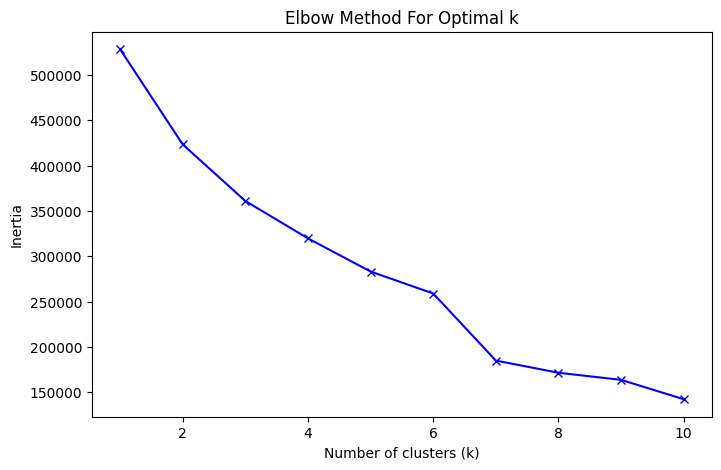

In [64]:
# ÏóòÎ≥¥Ïö∞ Í∏∞Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥ Ï†ÅÏ†àÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò Ï∞æÍ∏∞
inertia = []
K = range(1, 11)  # 1Î∂ÄÌÑ∞ 10ÍπåÏßÄÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏàòÎ•º ÌÖåÏä§Ìä∏

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# ÏóòÎ≥¥Ïö∞ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
# ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò
optimal_k = 7

# K-Means Î™®Îç∏ ÌïôÏäµ
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# Í∞Å Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Ïóê ÎåÄÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìï†Îãπ
merge_df_users_fin['cluster'] = kmeans.labels_

In [66]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÎπàÎèÑÏàò ÌôïÏù∏
merge_df_users_fin['cluster'].value_counts()

cluster
0    94370
4     9329
3     1820
1      140
5       20
2        3
6        1
Name: count, dtype: int64

In [67]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌÜµÍ≥Ñ ÌôïÏù∏
cluster_summary = merge_df_users_fin.groupby('cluster')[y_col].mean()
cluster_summary.reset_index()

cluster  total_engage_rate  net_subscribers_change  averageViewPercentage  \
0        0           0.017104               37.042641              35.398114   
1        1           0.087291            22630.200000              64.881164   
2        2           0.028571               -1.000000               4.223333   
3        3           0.021243              356.945604              31.063883   
4        4           0.077361              169.226176              30.277042   
5        5           0.031525               -1.450000              14.377500   
6        6           0.009141               -1.000000           15049.760000   

   revenue_per_view  gross_revenue_per_ad_impression  
0          1.407242                         2.739731  
1          0.098894                       299.350744  
2       1705.123363                         0.008333  
3          2.670372                       108.540397  
4          2.241624                         3.608885  
5        484.261921                         0.223413  
6          0.000000                         0.000000

In [68]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ yÍ∞í ÎπàÎèÑÏàò ÌôïÏù∏1 - Îã§Ï§ë ÏßÄÌëú ÌôúÏö©
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label'].value_counts()
cluster_summary

cluster  y_label
0        1          92601
         0           1769
1        0            140
2        0              3
3        0           1621
         1            199
4        1           7598
         0           1731
5        0             20
6        0              1
Name: count, dtype: int64

In [69]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ yÍ∞í ÎπàÎèÑÏàò ÌôïÏù∏2 - Í∞úÎ≥Ñ ÏßÄÌëú Ï¢ÖÌï©
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label2'].value_counts()
cluster_summary

cluster  y_label2
0        1           81214
         0           13156
1        0             140
2        0               3
3        0            1820
4        0            6406
         1            2923
5        0              20
6        0               1
Name: count, dtype: int64

In [70]:
# Ïù¥ÏÉÅÏπò Íµ∞Ïßë ÌôïÏù∏
merge_df_users_fin[merge_df_users_fin['cluster'].isin([1,2,5,6])]['channel_title'].unique()

array(['ÏûÑÏÇêÎÇò', nan, 'OBL - Ïò®ÎùºÏù∏ ÎÜçÎ∂Ä, ÏÇ¨ÏûêÍ∞Ä ÎêòÎã§', 'Íµ∞ÎåÄÏúÑÌÇ§', 'ÎØ∏ÎîîÌïòÎäîÎÇ®Ïûê',
       'Jeffreyxking', 'GMENCY Î©òÏãúÏùò ÎßàÏù∏ÌÅ¨ÎûòÌîÑÌä∏', 'Ï≤≠Ïñ¥ÎûåARMC'], dtype=object)

In [71]:
# Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Î™®Îç∏ Í≤∞Í≥º ÌôïÏù∏
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]['youtube_user_id'].unique())]['channel_title'].unique()

array(['ÏûÑÏÇêÎÇò', nan, 'MINLEE ÎØºÎ¶¨', 'OBL - Ïò®ÎùºÏù∏ ÎÜçÎ∂Ä, ÏÇ¨ÏûêÍ∞Ä ÎêòÎã§',
       'abbapraise ÏïÑÎ∞îÌîÑÎ†àÏù¥Ï¶à', 'Jeffreyxking', 'ÏΩúÎìúÏâΩ Coldsheep', 'kiuÍ∏∞Ïö∞Ïå§',
       'ÏàòÎπôÏàòtv sooBingsoo', 'ÎÑàÍµ¥Î™¨', 'ÏΩîÏù∏Îçï Ï∞®Ìä∏ÏïÑÏßÄ', 'ÎØ∏ÎãàÎ©ÄÏòÅÏñ¥ Minimal English',
       'Êó•Êú¨„Ç∏„Éå„ÄêÎãàÌòºÏßÄÎàÑ„Äë„ÉºÈüìÂõΩ„Å´Èñ¢„Åô„ÇãÂÖ®„Å¶', 'Î≤ΩÎèåÌï†ÏïÑÎ≤ÑÏßÄ Brick grandpa', 'Î∂ÅÌÜ†ÌÅ¨',
       'ÎÇòÏó∞Ïù¥Ï¶àÎ∞± LPGA Na Yeon Choi', 'Î∑∞ÎìúÎ¶Ñ Ïú†ÌäúÎ≤Ñ Ïù∏Ïî®', 'MerryMa Î©îÎ¶¨Îßà',
       "Î£®Îã§Ïùò ÎåÑÏä§ Ïó∞Íµ¨ÏÜå Ruda's Dance Lab", 'ÎπÖÎØº GAME', 'ÏûºÏä§Í∏∞ÌÉÄ', 'OSSC',
       'Îõ∞Îõ∞ÎπµÎπµ ÍπÄÏò•Ïàú', 'ÎèàÎÉÑÏÉà', 'ÌÇ§ÎÇòkkina', 'Ïù¥ÌòÑÏö∞Ïùò MLBTV', 'ÌïòÏõêÏû• Í∞ïÎèôÌòÑ', 'Ï£ºÌîºÏΩî'],
      dtype=object)

## ÏΩòÌÖêÏ∏† Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù

In [33]:
# ÏµúÏ¢Ö ÏΩòÌÖêÏ∏† Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÏÖã
# ÌôòÏú® Ï†ÅÏö© - Ìï¥ÎãπÍ∏∞Í∞Ñ ÌèâÍ∑†ÌôòÏú® : 1322.42
exchange_rate_col = ['estimatedRevenue', 'estimatedAdRevenue', 'estimatedRedPartnerRevenue', 'grossRevenue', 'cpm', 'playbackBasedCpm']
youtube_videos[exchange_rate_col] = youtube_videos[exchange_rate_col] * 1322.42

### Í∏∞Ï¥àÌÜµÍ≥Ñ

In [34]:
# Í∏∞Ï¥àÌÜµÍ≥Ñ
youtube_videos[youtube_videos.columns[20:]].describe()

cpm  subscribersGained  subscribersLost  monetizedPlaybacks  \
count  8.569511e+06       8.569511e+06     8.569511e+06        8.569511e+06   
mean   2.281787e+03       1.049081e+00     1.178471e-01        3.611802e+01   
std    8.802419e+03       2.968088e+01     7.033584e+00        7.577773e+02   
min    0.000000e+00       0.000000e+00     0.000000e+00        0.000000e+00   
25%    0.000000e+00       0.000000e+00     0.000000e+00        0.000000e+00   
50%    0.000000e+00       0.000000e+00     0.000000e+00        0.000000e+00   
75%    3.306050e+03       0.000000e+00     0.000000e+00        5.000000e+00   
max    5.280423e+06       2.142100e+04     1.151900e+04        5.134320e+05   

       adImpressions  cardClickRate  cardTeaserClickRate  cardImpressions  \
count   8.569511e+06   8.569511e+06         8.569511e+06     8.569511e+06   
mean    4.862698e+01   3.279751e-04         1.479624e-04     3.274866e-03   
std     1.121002e+03   1.610359e-02         9.179800e-03     3.155597e-01   
min     0.000000e+00   0.000000e+00         0.000000e+00     0.000000e+00   
25%     0.000000e+00   0.000000e+00         0.000000e+00     0.000000e+00   
50%     0.000000e+00   0.000000e+00         0.000000e+00     0.000000e+00   
75%     7.000000e+00   0.000000e+00         0.000000e+00     0.000000e+00   
max     6.542410e+05   1.000000e+00         4.000000e+00     3.480000e+02   

       cardTeaserImpressions    cardClicks  cardTeaserClicks  
count           8.569511e+06  8.569511e+06      8.569511e+06  
mean            2.203370e-01  8.963172e-04      1.660888e-03  
std             1.852126e+01  8.120112e-02      1.389403e-01  
min             0.000000e+00  0.000000e+00      0.000000e+00  
25%             0.000000e+00  0.000000e+00      0.000000e+00  
50%             0.000000e+00  0.000000e+00      0.000000e+00  
75%             0.000000e+00  0.000000e+00      0.000000e+00  
max             2.052100e+04  9.400000e+01      1.080000e+02

In [35]:
# ÏûòÎ™ªÎêúÍ∞í Ï≤òÎ¶¨
youtube_videos['estimatedRevenue'] = np.where(youtube_videos['estimatedRevenue'] < 0,
                                               youtube_videos['estimatedAdRevenue'] + youtube_videos['estimatedRedPartnerRevenue'],
                                               youtube_videos['estimatedRevenue'])

In [36]:
# Î≤ÑÍ∑∏Î°ú ÏÇ¨Ïö©Îêú ÏàòÏπòÍ∞í ÎåÄÏ≤¥
youtube_videos['likes'] = np.where(youtube_videos['likes'] < 0, 0, youtube_videos['likes'])
youtube_videos['dislikes'] = np.where(youtube_videos['dislikes'] < 0, 0, youtube_videos['dislikes'])

### ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ

In [37]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
video_corr_matrix = youtube_videos[youtube_videos.columns[3:]].corr()
video_corr_matrix

views  redViews  comments     likes  dislikes  \
views                       1.000000  0.748574  0.172572  0.931893  0.935864   
redViews                    0.748574  1.000000  0.156888  0.614375  0.674459   
comments                    0.172572  0.156888  1.000000  0.175911  0.178657   
likes                       0.931893  0.614375  0.175911  1.000000  0.861688   
dislikes                    0.935864  0.674459  0.178657  0.861688  1.000000   
shares                      0.847067  0.596769  0.169733  0.857807  0.781265   
estimatedMinutesWatched     0.797077  0.633769  0.153305  0.736375  0.723926   
estimatedRedMinutesWatched  0.284345  0.436308  0.086168  0.220131  0.237130   
averageViewDuration        -0.011406 -0.012772 -0.002572 -0.008103 -0.010890   
averageViewPercentage       0.015071  0.021436  0.004482  0.008686  0.013607   
videosAddedToPlaylists      0.543929  0.440095  0.130412  0.568199  0.474155   
videosRemovedFromPlaylists  0.254954  0.325922  0.086937  0.213555  0.195900   
estimatedRevenue            0.318394  0.412902  0.104338  0.244780  0.267804   
estimatedAdRevenue          0.074684  0.178675  0.049935  0.011773  0.029222   
grossRevenue                0.074698  0.178642  0.049919  0.011774  0.029225   
estimatedRedPartnerRevenue  0.188911  0.337125  0.071226  0.133162  0.148438   
playbackBasedCpm           -0.008235 -0.009959 -0.001697 -0.005464 -0.007579   
cpm                        -0.010237 -0.012226 -0.002007 -0.006790 -0.009434   
subscribersGained           0.719996  0.434398  0.136329  0.608671  0.750817   
subscribersLost             0.457673  0.298888  0.094826  0.465297  0.430041   
monetizedPlaybacks          0.080705  0.207690  0.058566  0.012873  0.029062   
adImpressions               0.079120  0.188833  0.052915  0.012491  0.029540   
cardClickRate               0.000275  0.002853  0.010470 -0.000337 -0.000159   
cardTeaserClickRate        -0.000448 -0.000210  0.000961 -0.000348 -0.000372   
cardImpressions             0.004494  0.014650  0.025878  0.000590  0.001951   
cardTeaserImpressions       0.008788  0.033207  0.038874  0.001366  0.004208   
cardClicks                  0.003392  0.013098  0.017999  0.000389  0.001427   
cardTeaserClicks            0.005424  0.018715  0.032310  0.000715  0.002352   

                              shares  estimatedMinutesWatched  \
views                       0.847067                 0.797077   
redViews                    0.596769                 0.633769   
comments                    0.169733                 0.153305   
likes                       0.857807                 0.736375   
dislikes                    0.781265                 0.723926   
shares                      1.000000                 0.690062   
estimatedMinutesWatched     0.690062                 1.000000   
estimatedRedMinutesWatched  0.247310                 0.675200   
averageViewDuration        -0.003241                 0.104230   
averageViewPercentage       0.008960                 0.005067   
videosAddedToPlaylists      0.574019                 0.593274   
videosRemovedFromPlaylists  0.275618                 0.473557   
estimatedRevenue            0.268022                 0.699625   
estimatedAdRevenue          0.073303                 0.530249   
grossRevenue                0.073257                 0.530288   
estimatedRedPartnerRevenue  0.167022                 0.614276   
playbackBasedCpm           -0.003681                 0.003066   
cpm                        -0.004572                 0.003507   
subscribersGained           0.615127                 0.580522   
subscribersLost             0.431097                 0.376579   
monetizedPlaybacks          0.077805                 0.482616   
adImpressions               0.072497                 0.513620   
cardClickRate               0.002083                 0.003896   
cardTeaserClickRate        -0.000005                 0.000081   
cardImpressions             0.004398                 0.020150   
cardTeaserImpression

### ÌååÏÉùÎ≥ÄÏàò

In [38]:
# ÌååÏÉùÎ≥ÄÏàò1 - Ï∞∏Ïó¨ÎèÑ Í¥ÄÎ†®
youtube_videos['like_rate'] = youtube_videos['likes'] / youtube_videos['views'] ## Ï¢ãÏïÑÏöî ÎπÑÏú® 
youtube_videos['comment_rate'] = youtube_videos['comments'] / youtube_videos['views'] ## ÎåìÍ∏Ä ÎπÑÏú®
youtube_videos['share_rate'] = youtube_videos['shares'] / youtube_videos['views'] ## Í≥µÏú† ÎπÑÏú®  
youtube_videos['dislike_rate'] = youtube_videos['dislikes'] / youtube_videos['views'] ## Ïã´Ïñ¥Ïöî ÎπÑÏú®
youtube_videos['total_engage_rate'] = (youtube_videos['likes'] + youtube_videos['comments'] + youtube_videos['shares'] + youtube_videos['dislikes']) / youtube_videos['views'] ## Ï¥ù Ï∞∏Ïó¨Ïú®
youtube_videos['positive_engage_rate'] = (youtube_videos['likes'] + youtube_videos['shares']) / youtube_videos['views'] ## Í∏çÏ†ïÏ†Å Ï∞∏Ïó¨Ïú®
youtube_videos['comment_to_like_rate'] = youtube_videos['comments'] / youtube_videos['likes'] ## ÎåìÍ∏Ä/Ï¢ãÏïÑÏöî ÎπÑÏú®
youtube_videos['like_to_dislike_ratio'] = youtube_videos['likes'] / (youtube_videos['dislikes']) ## Ï¢ãÏïÑÏöî/Ïã´Ïñ¥Ïöî ÎπÑÏú®

In [39]:
# ÌååÏÉùÎ≥ÄÏàò2 - Íµ¨ÎèÖÏûê Í¥ÄÎ†®
youtube_videos['net_subscribers_change'] = youtube_videos['subscribersGained'] - youtube_videos['subscribersLost'] ## Íµ¨ÎèÖÏûê ÏàúÏ¶ùÍ∞Ä
youtube_videos['subscribers_conversion_rate'] = youtube_videos['subscribersGained'] / youtube_videos['views'] ## Íµ¨ÎèÖÏûê Ï†ÑÌôòÏú®
youtube_videos['subscribers_gained_per_card_click'] = youtube_videos['subscribersGained'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ Íµ¨ÎèÖÏûê Ï¶ùÍ∞Ä
youtube_videos['subscribers_gained_per_playlist_add'] = youtube_videos['subscribersGained'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ Íµ¨ÎèÖÏûê Ï¶ùÍ∞Ä
youtube_videos['card_click_to_subscriber_conversion'] = youtube_videos['cardClickRate'] / youtube_videos['subscribersGained'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Î•† ÎåÄÎπÑ Íµ¨ÎèÖÏûê Ï†ÑÌôòÏú®
youtube_videos['subscribers_lost_per_playlist_remove'] = youtube_videos['subscribersLost'] / youtube_videos['videosRemovedFromPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï†úÍ±∞Îãπ Íµ¨ÎèÖÏûê ÏÜêÏã§

In [40]:
# ÌååÏÉùÎ≥ÄÏàò3 - ÏàòÏùµ Í¥ÄÎ†®
youtube_videos['revenue_per_view'] = youtube_videos['estimatedRevenue'] / youtube_videos['views'] ## Ï°∞ÌöåÏàòÎãπ ÏàòÏùµ
youtube_videos['revenue_per_red_view'] = youtube_videos['estimatedRevenue'] / youtube_videos['redViews'] ## ÌîÑÎ¶¨ÎØ∏ÏóÑÎãπ ÏàòÏùµ
youtube_videos['ad_revenue_rate'] = youtube_videos['estimatedAdRevenue'] / youtube_videos['estimatedRevenue'] ## Í¥ëÍ≥†ÏàòÏùµÎπÑÏú®
youtube_videos['red_revenue_rate'] = youtube_videos['estimatedRedPartnerRevenue'] / youtube_videos['estimatedRevenue'] ## ÌîÑÎ¶¨ÎØ∏ÏóÑÏàòÏùµÎπÑÏú®
youtube_videos['cpm_to_revenue_ratio'] = youtube_videos['cpm'] / youtube_videos['estimatedRevenue'] ## cpm ÎåÄÎπÑ ÏàòÏùµ
youtube_videos['revenue_per_ad_impression'] = youtube_videos['estimatedRevenue'] / youtube_videos['adImpressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂úÎãπ ÏàòÏùµ
youtube_videos['playback_based_cpm_rate'] = youtube_videos['playbackBasedCpm'] / youtube_videos['cpm'] ## Ïû¨ÏÉù Í∏∞Î∞ò ÏàòÏùµ
youtube_videos['revenue_per_card_click'] = youtube_videos['estimatedRevenue'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ ÏàòÏùµ
youtube_videos['revenue_per_playlist_add'] = youtube_videos['estimatedRevenue'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ ÏàòÏùµ
youtube_videos['card_click_to_revenue_ratio'] = youtube_videos['cardClickRate'] / youtube_videos['estimatedRevenue'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Î•† ÎåÄÎπÑ ÏàòÏùµ ÎπÑÏú®
youtube_videos['net_revenue_per_playlist_add'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['estimatedRevenue'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ ÏàúÏ∂îÍ∞ÄÎãπ ÏàòÏùµ
youtube_videos['ad_revenue_per_card_click'] = youtube_videos['estimatedAdRevenue'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ Í¥ëÍ≥† ÏàòÏùµ

In [41]:
# ÌååÏÉùÎ≥ÄÏàò4 - ÏãúÏ≤≠ ÏãúÍ∞Ñ Í¥ÄÎ†®
youtube_videos['revenue_per_minute_watched'] = youtube_videos['estimatedRevenue'] / youtube_videos['estimatedMinutesWatched'] ## ÏãúÏ≤≠ ÏãúÍ∞Ñ Îãπ ÏàòÏùµ
youtube_videos['revenue_per_minute_watched'] = youtube_videos['estimatedRevenue'] / youtube_videos['estimatedRedMinutesWatched'] ## ÌîÑÎ¶¨ÎØ∏ÏóÑ Ïù¥Ïö©Ïûê ÏãúÏ≤≠ ÏãúÍ∞Ñ Îãπ ÏàòÏùµ
youtube_videos['avg_view_duration_rate'] = youtube_videos['averageViewDuration'] / youtube_videos['averageViewPercentage'] ## ÌèâÍ∑† ÏãúÏ≤≠ ÏãúÍ∞Ñ ÎπÑÏú®
youtube_videos['watched_time_rate'] = youtube_videos['averageViewPercentage'] * youtube_videos['estimatedMinutesWatched'] ## Ïû¨ÏÉù ÎπÑÏú® ÎåÄÎπÑ ÏãúÏ≤≠ ÏãúÍ∞Ñ
youtube_videos['watched_time_red_rate'] = youtube_videos['averageViewPercentage'] * youtube_videos['estimatedRedMinutesWatched'] ## Ïû¨ÏÉù ÎπÑÏú® ÎåÄÎπÑ ÌîÑÎ¶¨ÎØ∏ÏóÑ Ïù¥Ïö©Ïûê ÏãúÏ≤≠ ÏãúÍ∞Ñ
youtube_videos['watched_view_rate'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['views'] ## Ï°∞ÌöåÏàòÎãπ ÏãúÏ≤≠ÏãúÍ∞Ñ
youtube_videos['watched_view_red_rate'] = youtube_videos['estimatedRedMinutesWatched'] / youtube_videos['views'] ## Ï°∞ÌöåÏàòÎãπ ÌîÑÎ¶¨ÎØ∏ÏóÑ Ïù¥Ïö©Ïûê ÏãúÏ≤≠ÏãúÍ∞Ñ
youtube_videos['watch_time_per_card_click'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ ÏãúÏ≤≠ ÏãúÍ∞Ñ
youtube_videos['watch_time_per_playlist_add'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ ÏãúÏ≤≠ ÏãúÍ∞Ñ
youtube_videos['avg_view_duration_per_card_click'] = youtube_videos['averageViewDuration'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠ ÎåÄÎπÑ ÌèâÍ∑† Ïû¨ÏÉù ÏãúÍ∞Ñ ÎπÑÏú®
youtube_videos['watch_time_loss_per_playlist_remove'] = youtube_videos['estimatedMinutesWatched'] / youtube_videos['videosRemovedFromPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï†úÍ±∞Îãπ ÏãúÏ≤≠ ÏãúÍ∞Ñ ÏÜêÏã§


In [42]:
# ÌååÏÉùÎ≥ÄÏàò5 - Í¥ëÍ≥† Í¥ÄÎ†®
youtube_videos['revenue_per_playback'] = youtube_videos['grossRevenue'] / youtube_videos['monetizedPlaybacks'] ## 1Ìöå Í¥ëÍ≥†Ïû¨ÏÉùÎãπ ÏàòÏùµ
youtube_videos['grossRevenue_per_ad_impression'] = youtube_videos['grossRevenue'] / youtube_videos['adImpressions'] ## 1Ìöå Í¥ëÍ≥†ÎÖ∏Ï∂úÎãπ Ï¥ùÏàòÏùµ
youtube_videos['playback_rate'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['adImpressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂ú ÎåÄÎπÑ Ïû¨ÏÉùÏú®
youtube_videos['unplayback_rate'] = (youtube_videos['adImpressions'] - youtube_videos['monetizedPlaybacks']) / youtube_videos['adImpressions'] ## Í¥ëÍ≥†ÎÖ∏Ï∂ú ÎåÄÎπÑ ÎπÑÏû¨ÏÉùÏú®
youtube_videos['revenue_per_card_click'] = youtube_videos['grossRevenue'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ ÏàòÏùµ
youtube_videos['revenue_per_playlist_add'] = youtube_videos['grossRevenue'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ ÏàòÏùµ
youtube_videos['card_click_to_revenue_ratio'] = youtube_videos['cardClickRate'] / youtube_videos['grossRevenue'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Î•† ÎåÄÎπÑ ÏàòÏùµ ÎπÑÏú®
youtube_videos['net_revenue_per_playlist_add'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['grossRevenue'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ ÏàúÏ∂îÍ∞ÄÎãπ ÏàòÏùµ
youtube_videos['ad_impressions_per_card_click'] = youtube_videos['adImpressions'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠Îãπ Í¥ëÍ≥† ÎÖ∏Ï∂ú
youtube_videos['ad_impressions_per_playlist_add'] = youtube_videos['adImpressions'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ Í¥ëÍ≥† ÎÖ∏Ï∂ú
youtube_videos['ad_playbacks_per_card_click'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['cardClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠ ÎåÄÎπÑ Í¥ëÍ≥† Ïû¨ÏÉù ÎπÑÏú®
youtube_videos['ad_playbacks_per_playlist_add'] = youtube_videos['monetizedPlaybacks'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞ÄÎãπ Í¥ëÍ≥† Ïû¨ÏÉù ÎπÑÏú®

In [43]:
# ÌååÏÉùÎ≥ÄÏàò6 - Ïπ¥Îìú Í¥ÄÎ†®
youtube_videos['card_to_teaser_click_rate'] = youtube_videos['cardClickRate'] / youtube_videos['cardTeaserClickRate'] ## Ïπ¥Îìú Ìã∞Ï†Ä ÌÅ¥Î¶≠Î•† ÎåÄÎπÑ Ïπ¥Îìú ÌÅ¥Î¶≠Î•†
youtube_videos['card_click_per_impression_rate'] = youtube_videos['cardClicks'] / youtube_videos['cardImpressions'] ## Ïπ¥Îìú ÎÖ∏Ï∂úÎãπ ÌÅ¥Î¶≠ ÎπÑÏú®
youtube_videos['card_teaser_click_per_impression_rate'] = youtube_videos['cardTeaserClicks'] / youtube_videos['cardTeaserImpressions'] ## Ïπ¥Îìú Ìã∞Ï†Ä ÎÖ∏Ï∂úÎãπ Ïπ¥Îìú Ìã∞Ï†Ä ÌÅ¥Î¶≠ ÎπÑÏú®
youtube_videos['total_card_teaser_click_rate'] = (youtube_videos['cardClicks'] + youtube_videos['cardTeaserClicks']) / (youtube_videos['cardImpressions'] + youtube_videos['cardTeaserImpressions']) ## Ïπ¥ÎìúÏôÄ Ïπ¥Îìú Ìã∞Ï†ÄÏùò Ï¥ù ÌÅ¥Î¶≠Î•†
youtube_videos['card_conversion_rate'] = youtube_videos['cardClicks'] / youtube_videos['cardTeaserClicks'] ## Ïπ¥Îìú ÌÅ¥Î¶≠ Ï†ÑÌôòÏú®

In [44]:
# ÌååÏÉùÎ≥ÄÏàò7 - ÎπÑÎîîÏò§ Í¥ÄÎ†®
youtube_videos['playlist_addition_rate'] = youtube_videos['videosAddedToPlaylists'] / youtube_videos['views'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞Ä ÎπÑÏú®
youtube_videos['playlist_removal_rate'] = youtube_videos['videosRemovedFromPlaylists'] / youtube_videos['views'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï†úÍ±∞ ÎπÑÏú®
youtube_videos['net_playlist_addition_rate'] = (youtube_videos['videosAddedToPlaylists'] - youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['views'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ ÏàúÏ∂îÍ∞Ä ÎπÑÏú®
youtube_videos['playlist_engagement_rate'] = (youtube_videos['videosAddedToPlaylists'] + youtube_videos['videosRemovedFromPlaylists']) / youtube_videos['views'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∞∏Ïó¨ÎèÑ
youtube_videos['playlist_related_revenue_rate'] = youtube_videos['estimatedRevenue'] / youtube_videos['videosAddedToPlaylists'] ## ÌîåÎ†àÏù¥Î¶¨Ïä§Ìä∏ Ï∂îÍ∞Ä Îãπ ÏàúÏàòÏùµ

In [45]:
# nullÍ∞í ÎåÄÏ≤¥
youtube_videos = youtube_videos.fillna(0) ## NaN
youtube_videos = youtube_videos.replace([np.inf, -np.inf], 0) ## inf

### ÏãúÍ≥ÑÏó¥ ÌôïÏù∏
- Looker Studio ÌôúÏö©

In [ ]:
# 'date' Ïª¨ÎüºÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
merge_df_users_fin['date'] = pd.to_datetime(merge_df_users_fin['date'])

# Ï£º(week) Ïª¨Îüº ÏÉùÏÑ± (ISO Ï£º Î≤àÌò∏ Í∏∞Ï§Ä)
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].dt.isocalendar().week
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_week'].astype(str)
merge_df_users_fin['date_week'] = pd.to_datetime(merge_df_users_fin['date_week'] + '-1', format='%Y-%W-%w') ## looker studio ÎÇ†Ïßú ÌòïÏãù ÏúÑÌï¥ Ï£ºÎßàÎã§ ÏõîÏöîÏùº ÎÇ†ÏßúÎ°ú Î≥ÄÍ≤Ω
merge_df_users_fin['date_week'] = merge_df_users_fin['date_week'].astype(str)

# Ïõî(month) Ïª¨Îüº ÏÉùÏÑ±
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].dt.month
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_month'].fillna(0).astype(int).astype(str)
merge_df_users_fin['date_month'] = np.where(merge_df_users_fin['date_month']=='NaT-0','',merge_df_users_fin['date_month'])

# Î∂ÑÍ∏∞(quarter) Ïª¨Îüº ÏÉùÏÑ±
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].dt.to_period('Q').dt.quarter
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_quarter'].fillna(0).astype(str)
merge_df_users_fin['date_quarter'] = np.where(merge_df_users_fin['date_quarter']=='NaT--1','',merge_df_users_fin['date_quarter'])

In [ ]:
merge_df_users_looker = merge_df_users_fin[['youtube_user_id','date','date_week','date_month','date_quarter','viewCount','subscriberCount','videoCount',
                                            'views','estimated_revenue','subscribers_count','estimatedMinutesWatched','averageViewDuration',
                                            'total_engage_rate','net_subscribers_change','averageViewPercentage','revenue_per_view',
                                            'female_viewer_rate', 'male_viewer_rate', 'youth_viewer_rate', 'adult_viewer_rate', 'older_viewer_rate']]

In [ ]:
# merge_df_users_looker.to_csv('C:/py_src/awake/data/merge_df_users_looker.csv', encoding='utf-8-sig', index=False)

### yÍ∞í ÏÑ§Ï†ï

#### Ï§ëÏöî ÏßÄÌëú ÌëúÏ§ÄÌôî

In [50]:
# yÍ∞í ÌôúÏö© ÏßÄÌëú
y_col = ['total_engage_rate', 'net_subscribers_change', 'averageViewPercentage', 'revenue_per_view', 'grossRevenue_per_ad_impression','total_card_teaser_click_rate','playlist_engagement_rate'] ## nullÍ∞íÏùÄ viewsÍ∞Ä 0Ïù∏ Îç∞Ïù¥ÌÑ∞

In [51]:
# nullÍ∞í ÎåÄÏ≤¥
youtube_videos[y_col] = youtube_videos[y_col].fillna(0) ## NaN
youtube_videos[y_col] = youtube_videos[y_col].replace([np.inf, -np.inf], 0) ## inf

In [52]:
# ÌëúÏ§ÄÌôî (Standard Scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(youtube_videos[y_col])

#### Îã§Ï§ë ÏßÄÌëú Í≤∞Ìï©

In [53]:
# Isolation Forest Î™®Îç∏ ÌïôÏäµ
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Ïù¥ÏÉÅÏπò ÎπÑÏú® ÏÑ§Ï†ï
iso_forest.fit(scaled_features)

# Ïù¥ÏÉÅÏπò Ï†êÏàò Í≥ÑÏÇ∞
anomaly_scores = iso_forest.decision_function(scaled_features)

In [54]:
# ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï
threshold = np.percentile(anomaly_scores, 5) ## Ïù¥ÏÉÅÏπò Ï†êÏàòÍ∞Ä ÏûëÏùÑÏàòÎ°ù Ïù¥ÏÉÅÏπòÏóê Í∞ÄÍπùÎã§Í≥† ÌåêÎã®ÌïòÎäîÎç∞, 5Î≤àÏß∏ Î∞±Î∂ÑÏúÑÏàòÍ∞Ä (-)Î°ú Î∞îÎÄåÎäî Ìè¨Ïù∏Ìä∏

# yÍ∞í ÎùºÎ≤®ÎßÅ (Ïù¥ÏÉÅÏπòÏù¥Î©¥ 0, Í∑∏Î†áÏßÄ ÏïäÏúºÎ©¥ 1)
youtube_videos['y_label'] = np.where(anomaly_scores < threshold, 0, 1)

In [55]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ yÍ∞í ÎπàÎèÑ ÌôïÏù∏
youtube_videos['y_label'].value_counts()

y_label
1    8141038
0     428473
Name: count, dtype: int64

In [56]:
# youtube_videos.to_csv('C:/py_src/awake/data/youtube_videos_eda.csv', encoding='utf-8-sig', index=False)

In [22]:
# Í≥ÑÏ†ïÎ≥Ñ yÍ∞í ÎπàÎèÑ Îç∞Ïù¥ÌÑ∞
youtube_videos.groupby('youtube_user_id')['y_label'].value_counts().reset_index()

youtube_user_id  y_label  count
0    627cb611aa6f212355e0b617        1  15241
1    627cb611aa6f212355e0b617        0    164
2    627f59ccaa39226247c60b01        1   8047
3    627f59ccaa39226247c60b01        0    507
4    6287228afb15712a8cb931d7        1   5131
..                        ...      ...    ...
493  65f7b17ed8da110bb0733b7b        0     86
494  65fecf7ed8da110bb0736199        1   8649
495  65fecf7ed8da110bb0736199        0    150
496  66230ee6d8da110bb0744b2d        1   3344
497  66230ee6d8da110bb0744b2d        0     56

[498 rows x 3 columns]

In [47]:
# ÏΩòÌÖêÏ∏†Î≥Ñ yÍ∞í ÎπàÎèÑ Îç∞Ïù¥ÌÑ∞
y_result_df = youtube_videos.groupby('video')['y_label'].value_counts().reset_index()

# ÏΩòÌÖêÏ∏†Î≥Ñ ÏùºÏùº Ï∏°Ï†ï Îç∞Ïù¥ÌÑ∞ Ïàò
video_cnt_df = youtube_videos.groupby('video')['end_date'].count().reset_index()

y_result_df = pd.merge(y_result_df,video_cnt_df,how='left',on='video')
y_result_df = y_result_df.rename(columns={'end_date':'total_count'})
y_result_df['standard_cnt'] = round(y_result_df['total_count'] * 0.1) ## ÎπÑÎîîÏò§Î≥Ñ ÏùºÏùº Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï§ë Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞Í∞Ä 10% Ïù¥ÏÉÅ
y_result_df['standard_cnt'] = y_result_df['standard_cnt'].astype(int)

y_result_df

video  y_label  count  total_count  standard_cnt
0       --0HSDH6J7o        1     15           15             2
1       --0XOlJ3Lw4        1    397          399            40
2       --0XOlJ3Lw4        0      2          399            40
3       --7sZPRc1H4        1     31           32             3
4       --7sZPRc1H4        0      1           32             3
...             ...      ...    ...          ...           ...
135441  zzlQiqh04eE        1     21           21             2
135442  zzwBOCOq5YI        1    308          342            34
135443  zzwBOCOq5YI        0     34          342            34
135444  zzza6bbJnMI        1    201          203            20
135445  zzza6bbJnMI        0      2          203            20

[135446 rows x 5 columns]

In [85]:
# Ïù¥ÏÉÅÏπò 1Í∞úÎùºÎèÑ ÏûàÎäî ÏΩòÌÖêÏ∏† ÌôïÏù∏
y_result_df[y_result_df['y_label']==0]['video']

2         --0XOlJ3Lw4
4         --7sZPRc1H4
6         --8Bucaa0Go
8         --FZnuz9-JQ
10        --FknkrtRXg
             ...     
135434    zzWuUVocjCI
135436    zz_dWlZVXJw
135438    zz_p_CzUMvw
135443    zzwBOCOq5YI
135445    zzza6bbJnMI
Name: video, Length: 49222, dtype: object

In [48]:
# Í≥ÑÏ†ïÎ≥Ñ ÏùºÏùºÎç∞Ïù¥ÌÑ∞Ïùò 10% Ïù¥ÏÉÅ Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞
video_outlier_df = y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] > y_result_df[y_result_df['y_label']==0]['standard_cnt']].reset_index(drop=True)
video_outlier_df

video  y_label  count  total_count  standard_cnt
0      --8Bucaa0Go        0     12           97            10
1      --stoDeuI_4        0      2            8             1
2      -0IyJ6nzgSg        0     18           87             9
3      -0JNe3se7JM        0     27          254            25
4      -0csgxlNcSc        0     14           68             7
...            ...      ...    ...          ...           ...
11164  zyf0BOV1V1s        0      9           58             6
11165  zyjbDedYZB8        0      1            5             0
11166  zypZyGqg9ZY        0      1            2             0
11167  zyyDUlfD4jg        0      7           48             5
11168  zzWuUVocjCI        0      2           11             1

[11169 rows x 5 columns]

In [55]:
# Ïù¥ÏÉÅÏπò Ï§ë Îç∞Ïù¥ÌÑ∞ Î∂ÄÏ°±ÏúºÎ°ú ÌåêÎã® Ïñ¥Î†§Ïö¥ Í≤É Ï†úÍ±∞ ÌõÑ ÏµúÏ¢Ö Ïù¥ÏÉÅÏπò ÏΩòÌÖêÏ∏†
video_outlier_fin = video_outlier_df[video_outlier_df['standard_cnt']!=0]['video'].unique()

In [62]:
# Í≥ÑÏ†ïÎ≥Ñ ÏΩòÌÖêÏ∏† Ïàò ÌôïÏù∏
youtube_videos.groupby('youtube_user_id')['video'].count().reset_index()

youtube_user_id  video
0    627cb611aa6f212355e0b617  15405
1    627f59ccaa39226247c60b01   8554
2    6287228afb15712a8cb931d7   5179
3    6287229efb15712a8cb93225  79977
4    628722c8fb15712a8cb9326e  34783
..                        ...    ...
244  65cc401305bf1c0baa425146  12038
245  65e7b773d8da110bb072e2b5   6196
246  65f7b17ed8da110bb0733b7b   2527
247  65fecf7ed8da110bb0736199   8799
248  66230ee6d8da110bb0744b2d   3400

[249 rows x 2 columns]

In [63]:
# Í≥ÑÏ†ïÎ≥Ñ Ïù¥ÏÉÅÏπò ÏΩòÌÖêÏ∏† Ïàò ÌôïÏù∏
youtube_videos[youtube_videos['video'].isin(video_outlier_fin)].groupby('youtube_user_id')['video'].count().reset_index()

youtube_user_id  video
0    627cb611aa6f212355e0b617    147
1    627f59ccaa39226247c60b01    700
2    6287229efb15712a8cb93225   1251
3    628722c8fb15712a8cb9326e   2052
4    62872317fb15712a8cb932e9   6734
..                        ...    ...
227  65cc401305bf1c0baa425146   5035
228  65e7b773d8da110bb072e2b5    641
229  65f7b17ed8da110bb0733b7b     41
230  65fecf7ed8da110bb0736199     31
231  66230ee6d8da110bb0744b2d     65

[232 rows x 2 columns]

In [65]:
# Í≥ÑÏ†ïÎ≥Ñ Ïù¥ÏÉÅÏπò ÏΩòÌÖêÏ∏† Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÏÖã
result_contents_df = pd.merge(youtube_videos.groupby('youtube_user_id')['video'].count().reset_index(),
                              youtube_videos[youtube_videos['video'].isin(video_outlier_fin)].groupby('youtube_user_id')['video'].count().reset_index(),
                              how='left',on='youtube_user_id')
result_contents_df = result_contents_df[~result_contents_df['video_y'].isnull()].reset_index(drop=True)

In [76]:
# Ïù¥ÏÉÅÏπò ÏΩòÌÖêÏ∏†Î•º ÎßéÏù¥ Í∞ñÍ≥† ÏûàÎäî Í≥ÑÏ†ï
result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]

youtube_user_id  video_x  video_y
4    62872317fb15712a8cb932e9    43332   6734.0
6    62872370fb15712a8cb93337    36478   5218.0
7    6287239cfb15712a8cb93368    22235   3358.0
18   62873efffb15712a8cb941a2    33547   6711.0
27   629c6ab9eaf5732d6deb9186    44321  19038.0
..                        ...      ...      ...
221  6551daa41120b40b442abd16     4034    449.0
222  65a3f25864b4250ba696579a    16318   6421.0
225  65bbb4a905bf1c0baa41e95c    10565   3373.0
227  65cc401305bf1c0baa425146    12038   5035.0
228  65e7b773d8da110bb072e2b5     6196    641.0

[77 rows x 3 columns]

In [80]:
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]['youtube_user_id'])]['channel_title'].unique()

array(['Ella', nan, 'hyeppening ÌòúÌîÑÎãù', 'KIMBEE ÌÇ¥ÎπÑ', 'ÏßÄÎãàÏõêÏû•ÏùòÌîºÎ∂ÄÌÜ°ÌÜ°', 'ÌùôÌöåÏû•',
       'Mind PattingÎßàÏùåÌÜ†Îã•', 'Î∞∞Ïö∞GO', 'MINLEE ÎØºÎ¶¨', 'ÏãúÍ≥®ÎÇ≠ÎßåÏïÑÏû¨', 'Ìô©ÎÇòÍ≤∏', 'ÎûòÏïÑTV',
       'sa lly', 'SATUR ÏÑ∏ÌÑ∞ÏóÖ', 'Ïù¥Ïà≤soop', 'ÎûòÎù† LAETI',
       'OBL - Ïò®ÎùºÏù∏ ÎÜçÎ∂Ä, ÏÇ¨ÏûêÍ∞Ä ÎêòÎã§', 'ÏãúÎ¶¨Ïñº Sireal', 'ÏÑúÏú† SEOYU DANCE',
       'ORlGN Ïò§Î¶¨ÏßÑ', 'abbapraise ÏïÑÎ∞îÌîÑÎ†àÏù¥Ï¶à', 'ÏûâÌà∞TV- ÎßåÌôîÎ°ú ÏâΩÍ≤å ÏòÅÏñ¥Î∞∞Ïö∞Ïûê',
       'Î™®ÌïòÏßÄÏó∞ MOHAJIYEON', 'Î∂ÄÎ∞òTV_Î∂ÄÏóê Î∞òÌïòÎã§', 'ÍπÄÎëêÎ∂Ä', 'ÎùºÎÇòÏ†úÏù¥Î≤†Ïù¥ÌÇπLana J', 'ÎØ∏ÎîîÌïòÎäîÎÇ®Ïûê',
       'Jeffreyxking', 'Î∞îÎùºÎçò Î∞îÎã§ BADACHANNEL', 'ÏõîÌÖçÎÇ® - ÏõîÏä§Ìä∏Î¶¨Ìä∏ ÌÖåÌÅ¨ÎÇ®', 'ÎπÑÎê¥ÌÅ¥ÎûòÏä§',
       'ÎßåÎä•ÌòÅÌÇ§', 'DalhaeÎã¨Îã¨Ìï¥', 'Ïñ¥Ïõ®Ïù¥Ïª§ | ÌÅ¨Î¶¨ÏóêÏù¥ÌÑ∞ Ïù¥ÏΩîÎÖ∏ÎØ∏',
       'ÏÑùÏãúÏõê Ïª§Ìîå SeokSiWon Couple', 'ÌÉúÍ∂åÎØºÍµ≠_Captain Master', 'ÎÑàÍµ¥Î™¨', 'ÎîîÏßÄÌÑ∏ÏÉùÌôúÏ†úÏïà',
       'ÎØ∏ÎãàÎ©ÄÏòÅÏñ¥ Minimal English', 'Ï≤≠Ïñ¥ÎûåARMC', 'Ood Ïò§Îìú', '

#### Íµ∞ÏßëÎ∂ÑÏÑù

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

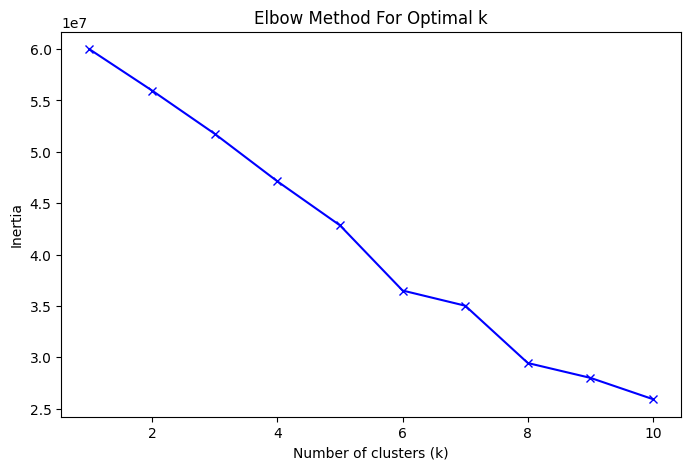

In [90]:
# ÏóòÎ≥¥Ïö∞ Í∏∞Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥ Ï†ÅÏ†àÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò Ï∞æÍ∏∞
inertia = []
K = range(1, 11)  # 1Î∂ÄÌÑ∞ 10ÍπåÏßÄÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞ ÏàòÎ•º ÌÖåÏä§Ìä∏

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# ÏóòÎ≥¥Ïö∞ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [96]:
# ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò
optimal_k = 8

# K-Means Î™®Îç∏ ÌïôÏäµ
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# Í∞Å Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Ïóê ÎåÄÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞ Ìï†Îãπ
youtube_videos['cluster'] = kmeans.labels_

In [97]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÎπàÎèÑÏàò ÌôïÏù∏
youtube_videos['cluster'].value_counts()

cluster
4    8447882
0     117581
3       2095
1        915
7        723
6        304
5          8
2          3
Name: count, dtype: int64

In [98]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌÜµÍ≥Ñ ÌôïÏù∏
cluster_summary = youtube_videos.groupby('cluster')[y_col].mean()
cluster_summary.reset_index()

cluster  total_engage_rate  net_subscribers_change  averageViewPercentage  \
0        0           0.637679                0.073073              58.979562   
1        1           0.084833             1726.257923              80.653071   
2        2           0.000000                0.000000              44.130000   
3        3           0.023175                0.943198              32.828644   
4        4           0.013488                0.756414              49.290731   
5        5           0.000000                0.000000              13.711250   
6        6           0.033639                0.009868           10960.412401   
7        7           0.025967                0.033195              33.770401   

   revenue_per_view  grossRevenue_per_ad_impression  \
0          1.691165                        1.697127   
1          0.081326                        0.048998   
2          0.000000                        0.000000   
3          2.863418                        6.823739   
4          1.413274                        2.250632   
5      19312.125772                        0.000000   
6          0.070652                        0.021750   
7       1162.176524                      452.020859   

   total_card_teaser_click_rate  playlist_engagement_rate  
0                      0.000004                  0.060089  
1                      0.000004                  0.001217  
2                      0.000000                677.833333  
3                      0.461026                  0.024624  
4                      0.000045                  0.018517  
5                      0.000000                  0.000000  
6                      0.000000                  0.006829  
7                      0.000000                  0.031302

In [99]:
# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ yÍ∞í ÎπàÎèÑÏàò ÌôïÏù∏1 - Îã§Ï§ë ÏßÄÌëú ÌôúÏö©
cluster_summary = youtube_videos.groupby('cluster')['y_label'].value_counts()
cluster_summary

cluster  y_label
0        0            83815
         1            33766
1        0              915
2        0                3
3        1             1725
         0              370
4        1          8105547
         0           342335
5        0                8
6        0              304
7        0              723
Name: count, dtype: int64

In [108]:
# Ïù¥ÏÉÅÏπò Íµ∞Ïßë ÌôïÏù∏
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(youtube_videos[youtube_videos['cluster'].isin([1,2,5,6,7])]['youtube_user_id'].unique())]['channel_title'].unique()

array(['ÏÑ∏ÎÇ®Ïûê Î¨ºÍ≥†Í∏∞', nan, 'Îù†Ìòú ddihye', 'ÏÜåÎ¶¨ÎØ∏Ïùò Ïã†ÌôîÎ∞©ÏÜ°', 'Ella', 'Ï∞åÎäâ',
       'hyeppening ÌòúÌîÑÎãù', 'KIMBEE ÌÇ¥ÎπÑ', 'Î¶ÑÏø† ·¥ò ü·¥Ä è ü…™Íú±·¥õ', 'ÏûÑÏÇêÎÇò', 'ÎÇòÎäî Î∂àÎèÖ',
       'Î∞îÎ•∏Í±∏ÏùåÏó∞Íµ¨ÏÜå', 'ÏûÑÌì®Ïùò ÎπÑÌä∏Î©îÏù¥ÌÇπ ÌÅ¥ÎûòÏä§', 'Ï∞®Î∞ïÏî¨', 'ÏßÄÎãàÏõêÏû•ÏùòÌîºÎ∂ÄÌÜ°ÌÜ°', 'Ïò§ÎäòÎèÑÌù¨Îã§ HEEDA',
       'ÎÇ≠ÎßåÏïÑÏ†ÄÏî®ÏΩîÎîîTV', 'Kevin FactoryÏºÄÎπàÌå©ÌÜ†Î¶¨', 'assesta', 'JinBlog ÏßÑÎ∏îÎ°úÍ∑∏',
       'ÌùôÌöåÏû•', 'Ïú†ÏùµÌïú Í∑†ÌäúÎ≤Ñ', 'Ï∞®ÏÑ∏Ïù¥CHASEYi', 'Mind PattingÎßàÏùåÌÜ†Îã•', '1Î∂ÑÎâ¥Ïä§', 'Î∞∞Ïö∞GO',
       'the sence', 'MINLEE ÎØºÎ¶¨', 'ÏãúÍ≥®ÎÇ≠ÎßåÏïÑÏû¨', 'Ìô©ÎÇòÍ≤∏', 'ÏÑ±ÌïúÏ§Ä', 'Îã§Î®πÏñ¥ÎùºÏù¥Ïñ∏',
       'ÌïòÎ∂ÄÏú†ÌäúÎ∏å Minor / (Lower) YouTube', 'Seol-A ÎùºÏù¥Îçî ÏÑ§ÏïÑ', 'SATUR ÏÑ∏ÌÑ∞ÏóÖ',
       'ÏàòÏßëÏùò ÏàòÏßë', 'Íµ•ÌîåÎ†àÏù¥Ïä§ ÎßõÏßëÌà¨Ïñ¥', 'Ïù¥Ïà≤soop', 'ÎûòÎù† LAETI',
       'OBL - Ïò®ÎùºÏù∏ ÎÜçÎ∂Ä, ÏÇ¨ÏûêÍ∞Ä ÎêòÎã§', 'ÏãúÎ¶¨Ïñº Sireal', 'ÏÑúÏú† SEOYU DANCE',
       'abbapraise ÏïÑÎ∞îÌîÑÎ†àÏù¥Ï¶à', 'ÏúàÌîåÏ¶

In [109]:
# Ïù¥ÏÉÅÏπò ÌÉêÏßÄ Î™®Îç∏ Í≤∞Í≥º ÌôïÏù∏
merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(result_contents_df[(result_contents_df['video_y'] / result_contents_df['video_x']) > 0.1]['youtube_user_id'])]['channel_title'].unique()

array(['Ella', nan, 'hyeppening ÌòúÌîÑÎãù', 'KIMBEE ÌÇ¥ÎπÑ', 'ÏßÄÎãàÏõêÏû•ÏùòÌîºÎ∂ÄÌÜ°ÌÜ°', 'ÌùôÌöåÏû•',
       'Mind PattingÎßàÏùåÌÜ†Îã•', 'Î∞∞Ïö∞GO', 'MINLEE ÎØºÎ¶¨', 'ÏãúÍ≥®ÎÇ≠ÎßåÏïÑÏû¨', 'Ìô©ÎÇòÍ≤∏', 'ÎûòÏïÑTV',
       'sa lly', 'SATUR ÏÑ∏ÌÑ∞ÏóÖ', 'Ïù¥Ïà≤soop', 'ÎûòÎù† LAETI',
       'OBL - Ïò®ÎùºÏù∏ ÎÜçÎ∂Ä, ÏÇ¨ÏûêÍ∞Ä ÎêòÎã§', 'ÏãúÎ¶¨Ïñº Sireal', 'ÏÑúÏú† SEOYU DANCE',
       'ORlGN Ïò§Î¶¨ÏßÑ', 'abbapraise ÏïÑÎ∞îÌîÑÎ†àÏù¥Ï¶à', 'ÏûâÌà∞TV- ÎßåÌôîÎ°ú ÏâΩÍ≤å ÏòÅÏñ¥Î∞∞Ïö∞Ïûê',
       'Î™®ÌïòÏßÄÏó∞ MOHAJIYEON', 'Î∂ÄÎ∞òTV_Î∂ÄÏóê Î∞òÌïòÎã§', 'ÍπÄÎëêÎ∂Ä', 'ÎùºÎÇòÏ†úÏù¥Î≤†Ïù¥ÌÇπLana J', 'ÎØ∏ÎîîÌïòÎäîÎÇ®Ïûê',
       'Jeffreyxking', 'Î∞îÎùºÎçò Î∞îÎã§ BADACHANNEL', 'ÏõîÌÖçÎÇ® - ÏõîÏä§Ìä∏Î¶¨Ìä∏ ÌÖåÌÅ¨ÎÇ®', 'ÎπÑÎê¥ÌÅ¥ÎûòÏä§',
       'ÎßåÎä•ÌòÅÌÇ§', 'DalhaeÎã¨Îã¨Ìï¥', 'Ïñ¥Ïõ®Ïù¥Ïª§ | ÌÅ¨Î¶¨ÏóêÏù¥ÌÑ∞ Ïù¥ÏΩîÎÖ∏ÎØ∏',
       'ÏÑùÏãúÏõê Ïª§Ìîå SeokSiWon Couple', 'ÌÉúÍ∂åÎØºÍµ≠_Captain Master', 'ÎÑàÍµ¥Î™¨', 'ÎîîÏßÄÌÑ∏ÏÉùÌôúÏ†úÏïà',
       'ÎØ∏ÎãàÎ©ÄÏòÅÏñ¥ Minimal English', 'Ï≤≠Ïñ¥ÎûåARMC', 'Ood Ïò§Îìú', '